# BNB Linked Data Platform

The [BNB Linked Data Platform](https://bnb.data.bl.uk/) provides access to the [British National Bibliography (BNB)](http://www.bl.uk/bibliographic/natbib.html) published as linked open data and made available through SPARQL services. 

This notebook explains how to query the repository and obtain places of publication (fields blt:publication and blt:projectedPublication ) to show an interactive map. Thanks that the works are linked to [GeoNames](https://www.geonames.org/), the records can be linked to external repositories. This notebook  obtains information from [Wikidata](https://www.wikidata.org), showing the benefits of Linked Open Data.

## Global configuration

In this section, you can set the author from the BNB by using its identifier. 

In [1]:
#bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/DickensCharles1812-1870'
#bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/BlakeWilliam1757-1827'
#bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/WoolfVirginia1882-1941'
bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/ShakespeareWilliam1564-1616'

## Setting up things

In [2]:
import folium
import requests
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize  

## Let's query the repository by asking the publications related to William Shakespeare
We will use the [SPARQL endpoint](https://bnb.data.bl.uk/flint-sparql) to create the query and configure the request to retrieve json as a result.

In [3]:
url = 'https://bnb.data.bl.uk/sparql'
query = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
PREFIX bio: <http://purl.org/vocab/bio/0.1/>
PREFIX blt: <http://www.bl.uk/schemas/bibliographic/blterms#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX event: <http://purl.org/NET/c4dm/event.owl#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX isbd: <http://iflastandards.info/ns/isbd/elements/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdau: <http://rdaregistry.info/Elements/u/>
PREFIX madsrdf: <http://www.loc.gov/mads/rdf/v1#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX umbel: <http://umbel.org/umbel#>
PREFIX schema: <http://schema.org/>
PREFIX c4dm: <http://purl.org/NET/c4dm/event.owl#>

SELECT DISTINCT ?resource ?title ?date ?place WHERE {{
    graph <http://bnb.data.bl.uk/id/graph/BNBCIP> {{
      ?resource ?p <{0}> ;
         dct:title ?title ;
         schema:datePublished ?date .
      OPTIONAL {{
          ?resource blt:projectedPublication ?publication .
          ?publication c4dm:place ?place .
          FILTER regex(?place, "geonames", "i")        
      }}
      OPTIONAL {{
          ?resource blt:publication ?publication .
          ?publication c4dm:place ?place .
          FILTER regex(?place, "geonames", "i")        
      }}
    }}
}} LIMIT 500
"""

query = query.format(bnbIdAuthor)

# use json as a result
headers = {'Accept': 'application/sparql-results+json'}
r = requests.get(url, params = {'format': 'application/sparql-results+json', 'query': query}, headers=headers)
print('Elements retrieved!')
print(r.text)

Elements retrieved!

{ "head": { "link": [], "vars": ["resource", "title", "date", "place"] },
  "results": { "distinct": false, "ordered": true, "bindings": [
    { "resource": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/013310275" }	, "title": { "type": "literal", "value": "Macbeth : teachit KS3 interactive pack" }	, "date": { "type": "literal", "value": "2006-01" }	, "place": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},
    { "resource": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/013310276" }	, "title": { "type": "literal", "value": "Much ado about nothing : teachit KS3 interactive pack" }	, "date": { "type": "literal", "value": "2006-01" }	, "place": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},
    { "resource": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/013315368" }	, "title": { "type": "literal", "value": "Hamlet" }	, "date": { "type": "literal", "value": "2006-01" }	, "place": { "type": 

## Save as a CSV 

In [4]:
bnbdata = json.loads(r.text)

with open('bnb_records.csv', 'w', newline='') as file:
    csv_out = csv.writer(file, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)    

    #csv_out = csv.writer(open('bnb_records.csv', 'w'), delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
    csv_out.writerow(['resource', 'place', 'title', 'date'])

    for i in bnbdata['results']['bindings']:
        resource = place = title = date =''

        resource = i['resource']['value']
        #if "place" in i:
        place = i['place']['value']
        title = i['title']['value']
        date = i['date']['value']

        csv_out.writerow([resource,place,title,date])

## Exploring the data

In [5]:
# Load the CSV file from GitHub.
# This puts the data in a Pandas DataFrame
df = pd.read_csv('bnb_records.csv')

In [6]:
df

,resource,place,title,date
0,http://bnb.data.bl.uk/id/resource/013310275,http://sws.geonames.org/6269131/,Macbeth : teachit KS3 interactive pack,2006-01
1,http://bnb.data.bl.uk/id/resource/013310276,http://sws.geonames.org/6269131/,Much ado about nothing : teachit KS3 interacti...,2006-01
2,http://bnb.data.bl.uk/id/resource/013315368,http://sws.geonames.org/6269131/,Hamlet,2006-01
3,http://bnb.data.bl.uk/id/resource/019599478,http://sws.geonames.org/6269131/,Twelfth night,2020-01
4,http://bnb.data.bl.uk/id/resource/019599479,http://sws.geonames.org/6269131/,The tempest : the alexander text,2019-11
...,...,...,...,...
135,http://bnb.data.bl.uk/id/resource/019806992,http://sws.geonames.org/6252001/,The taming of the shrew,2020-05
136,http://bnb.data.bl.uk/id/resource/019806993,http://sws.geonames.org/6252001/,The merchant of Venice,2020-05
137,http://bnb.data.bl.uk/id/resource/019806994,http://sws.geonames.org/6252001/,Sonnets,2020-05
138,http://bnb.data.bl.uk/id/resource/019806995,http://sws.geonames.org/6252001/,Twelfth night,2020-05


## How many items?

In [7]:
# How many items?
len(df)

140

### Let's count the number of resources per place

In [13]:
places_by_number = df.groupby("place")["resource"].count()

In [14]:
places_by_number

place
http://sws.geonames.org/1269750/     2
http://sws.geonames.org/2921044/     9
http://sws.geonames.org/6251999/     2
http://sws.geonames.org/6252001/    42
http://sws.geonames.org/6269131/    85
Name: resource, dtype: int64

In [57]:
### We can access the count of each place

In [58]:
places_by_number[['http://sws.geonames.org/6269131/']][0]

85

### Create a chart to visualize the results
This chart shows the number of resources by date.

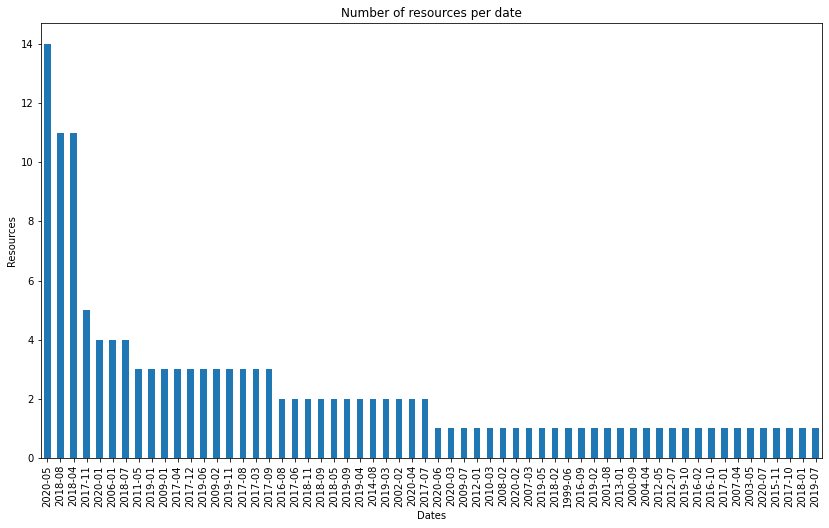

In [59]:
ax = df['date'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of resources per date")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()

### Let's group the items by year

In [60]:
# First we create a new column in pandas with the year
df['year'] = pd.DatetimeIndex(df['date']).year

In [61]:
df['year']

0      2006
1      2006
2      2006
3      2020
4      2019
       ... 
135    2020
136    2020
137    2020
138    2020
139    2020
Name: year, Length: 140, dtype: int64

### Creating the chart by year

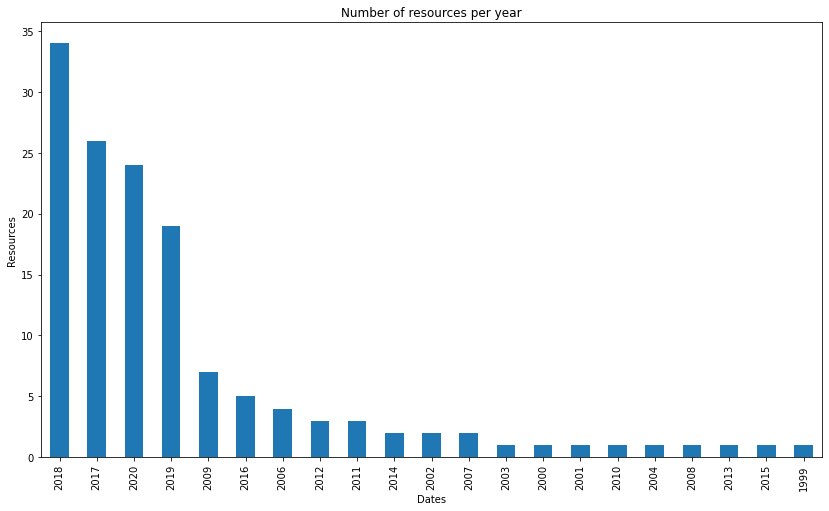

In [62]:
ax = df['year'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of resources per year")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()

## Exploring the places

In [15]:
# Get unique values
places = pd.unique(df['place']).tolist()
strplaces = ''
for a in sorted(places):
    print(a)
    strplaces = strplaces + ' \"' + a.replace("http://sws.geonames.org/", "").replace("/", "") + '\"'
print(strplaces)

http://sws.geonames.org/1269750/
http://sws.geonames.org/2921044/
http://sws.geonames.org/6251999/
http://sws.geonames.org/6252001/
http://sws.geonames.org/6269131/
 "1269750" "2921044" "6251999" "6252001" "6269131"


### Getting latitude and longitude from Wikidata

In [16]:
url = 'https://query.wikidata.org/sparql'
query = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE {{ 
  values ?idgeonames {{ {0} }} 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
}}
"""

query = query.format(strplaces)
print(query)

# use json as a result
r = requests.get(url, params = {'format': 'json', 'query': query})
geopoints = r.json()


PREFIX bibo: <http://purl.org/ontology/bibo/>
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE { 
  values ?idgeonames {  "1269750" "2921044" "6251999" "6252001" "6269131" } 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}



### Finally, we add the markers to the map

In [17]:
map = folium.Map(location=[0,0], zoom_start=1.5)

for geo in geopoints['results']['bindings']:
    idwikidata = geo['x']['value']
    lat = geo['lat']['value']
    lon = geo['lon']['value']
    idgeonames = geo['idgeonames']['value']
    label = geo['xLabel']['value']
    print(lat, lon)
    
    # adding a text to the popup
    count = places_by_number[['http://sws.geonames.org/' + idgeonames + '/']][0]
    popup = str(count) + " records published in <a hreh='" + str(idwikidata) + "'>" + label + "</a>"
    
    folium.Marker([lat,lon], popup= popup).add_to(map)

51.0 10.0
22.8 83.0
53.0 -1.0
56.0 -109.0
39.828175 -98.5795


In [44]:
map